In [1]:
from google.colab import drive
drive.mount('/content/drive')
# 必要ならば以下のようにディレクトリ移動する
%cd /content/drive/'My Drive'/'Google Colab'/

%tensorflow_version 2.x

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Google Colab
TensorFlow 2.x selected.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf

print(tf.__version__)

2.1.0


In [0]:
def readRainA(_csv_path):

  input_csv = pd.read_csv(filepath_or_buffer=_csv_path, encoding="shift_jis", sep=",", dtype=str)
  a = input_csv[['朝日前坂','下山','上大納','小黒見','浄土寺川ダム','下黒谷','奥越土木','小舟渡','牧福島','永平寺ダム', '東古市']]
  a = a.rename(columns={'小舟渡': '勝山分庁舎'})
  b = a.replace('-', 'NaN')

  return b

def readRainB(_csv_path):

  input_csv = pd.read_csv(filepath_or_buffer=_csv_path, encoding="shift_jis", sep=",", dtype=str)
  a = input_csv[['朝日前坂','下山','上大納','小黒見','浄土寺川ダム','下黒谷','奥越土木','勝山分庁舎','牧福島','永平寺ダム', '東古市']]
  b = a.replace('-', 'NaN')

  return b

def readRiver(_csv_path):

  input_csv = pd.read_csv(filepath_or_buffer=_csv_path, encoding="shift_jis", sep=",", dtype=str)
  a = input_csv[['日時','松丸','比島','小舟渡']]
  a = a.rename(columns={'松丸': '水位:松丸'})
  a = a.rename(columns={'比島': '水位:比島'})
  a = a.rename(columns={'小舟渡': '水位:小舟渡'})
  b = a.replace('-', 'NaN')
  c = b.drop(b.index[[0, b.shape[0]-1]])

  return c

def getKofunatoSuii(_csv_path):

  input_csv = pd.read_csv(filepath_or_buffer=_csv_path, encoding="shift_jis", sep=",", dtype=str)
  a = input_csv[['小舟渡']]
  a_suii = a.drop(a.index[[0, a.shape[0]-1]])
  a_suii = a_suii.replace('-', 'NaN').fillna(method='ffill')
  a_suii['mean'] = a_suii.rolling(24, center=True).mean()

  x = np.arange(1, a_suii.shape[0]+1)
  ss = a_suii['小舟渡'].values.astype(np.float32)
  y =  ss - a_suii['mean'].values.astype(np.float32)


  maxid = np.array(signal.argrelmax(y, order=1))
  a_suii['diff'] = y

  z = np.zeros(y.shape[0])
  for i in maxid:
    z[i] = 1

  a_suii['argrelmax'] = z

  dst = pd.DataFrame(data=np.array(a_suii), columns=a_suii.columns)
  return dst

def getRangeData(_src_data, _target, _tapB, _tapA):
  
  tgt_data = _src_data.copy()
  tgt_data['src_indx'] = np.arange(_src_data.shape[0])

  tgt_data = tgt_data[(tgt_data['src_indx'] >= _target-_tapB)&(tgt_data['src_indx'] <= _target+_tapA)]

  return tgt_data

def getYearData(_tgt_year):

  strYear = str(_tgt_year)

  dataRiver = readRiver("/content/drive/My Drive/Google Colab/river/jikokusuii" + strYear + ".csv")

  if _tgt_year > 2013:
    dataRain = readRainA("/content/drive/My Drive/Google Colab/rain/jikanuryou" + strYear + ".csv")
  else:
    dataRain = readRainB("/content/drive/My Drive/Google Colab/rain/jikanuryou" + strYear + ".csv")

  a = pd.DataFrame(data=np.array(dataRiver), columns=dataRiver.columns)
  b = pd.DataFrame(data=np.array(dataRain), columns=dataRain.columns)
  c=pd.concat([a, b], axis=1)

  d=getKofunatoSuii("/content/drive/My Drive/Google Colab/river/jikokusuii" + strYear + ".csv")

  c['mean'] = d['mean'].values.astype(np.float32)
  c['diff'] = d['diff'].values.astype(np.float32)
  c['argrelmax'] = d['argrelmax'].values.astype(np.float32)
  
  return c

def getYearPeak(_tgt_data):

  #data_peak = now_data[(now_data['diff'] > 0.1) & (now_data['argrelmax'] > 0.5) & (now_data['水位:小舟渡'] > 0.8)]
  data_peak = _tgt_data[(_tgt_data['diff'] > 0.1) & (_tgt_data['argrelmax'] > 0.5) & (_tgt_data['水位:小舟渡'].values.astype(np.float32) > 0.9)]
  #data_peak = now_data[(now_data['水位:小舟渡'] > 0.8)]

  x = _tgt_data.index.values
  y = _tgt_data['水位:小舟渡'].values.astype(np.float32)
  z = data_peak.index.values

  plt.plot(x, y)
  plt.plot(x[z], y[z], 'ro')

  print(_tgt_data.columns.values)

  return data_peak

def selectUseData001(_src_data):
  
  target_data = pd.DataFrame(_src_data['水位:小舟渡'].values.astype(np.float32), index=_src_data['日時'].values, columns=['target']) 
  target_data['river_0'] = _src_data['水位:松丸'].values.astype(np.float32)
  target_data['river_1'] = _src_data['水位:比島'].values.astype(np.float32)
  target_data['rain_0'] = _src_data['朝日前坂'].values.astype(np.float32)
  target_data['rain_1'] = _src_data['下山'].values.astype(np.float32)
  target_data['rain_2'] = _src_data['上大納'].values.astype(np.float32)
  target_data['rain_3'] = _src_data['小黒見'].values.astype(np.float32)
  target_data['rain_4'] = _src_data['浄土寺川ダム'].values.astype(np.float32)
  target_data['rain_5'] = _src_data['下黒谷'].values.astype(np.float32)
  target_data['rain_6'] = _src_data['奥越土木'].values.astype(np.float32)
  target_data['rain_7'] = _src_data['牧福島'].values.astype(np.float32)
  target_data['rain_8'] = _src_data['永平寺ダム'].values.astype(np.float32)
  target_data['rain_9'] = _src_data['東古市'].values.astype(np.float32)
  target_data['rain_10'] = _src_data['勝山分庁舎'].values.astype(np.float32)

  print(target_data.shape)
  #print(target_data.isnull().sum())
  target_data = target_data.fillna(method='ffill')
  target_data = target_data.fillna(method='bfill')

  return target_data




2012, 2013, 2015

In [5]:
target_data = pd.concat([selectUseData001(getYearData(2012)),
                           selectUseData001(getYearData(2013)),
                           selectUseData001(getYearData(2015)),
                           selectUseData001(getYearData(2016))])

/tensorflow-2.1.0/python3.6/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/tensorflow-2.1.0/python3.6/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


(8784, 14)
(8760, 14)
(8760, 14)
(8784, 14)


In [7]:
dataset = target_data.values.astype(np.float32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) - 8784)
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape, test.shape)

(26304, 14) (8784, 14)


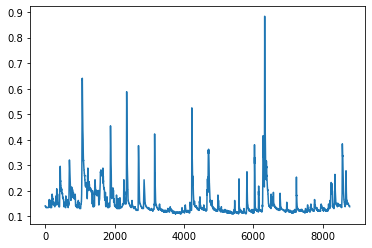

In [156]:
plt.plot(test[:, 0])

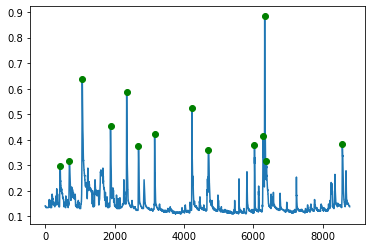

In [41]:
target_dt2016 =[ 431, 695, 1066, 1882, 2348, 2688, 3155, 4229, 4705, 6037, 6285, 6331, 6380, 8572]

plt.plot(test[:, 0])
plt.plot(target_dt2016, test[target_dt2016, 0], 'go')


## 1時間後の小舟渡の水位を予測

In [8]:
def create_dataset01(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)

        dataY.append(dataset[i + look_back, 0])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

look_back = 6

trainX01, trainY01 = create_dataset01(train, look_back)
testX01, testY01 = create_dataset01(test, look_back)
print(trainX01.shape, trainY01.shape)
print(testX01.shape, testY01.shape)

(26297, 14, 6) (26297,)
(8777, 14, 6) (8777,)


In [9]:
# create and fit the LSTM network
model01 = tf.keras.Sequential()
model01.add(tf.keras.layers.LSTM(20, input_shape=(trainX01.shape[1], trainX01.shape[2])))	#shape：変数数、遡る時間数
model01.add(tf.keras.layers.Dense(1))
model01.compile(loss='mean_squared_error', optimizer='adam')
model01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2160      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_sropping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=20)

history = model01.fit(trainX01, trainY01, 
                      epochs=1000,
                      batch_size=128, 
                      verbose=2,
                      validation_split=0.2,
                      callbacks=[early_sropping])

Train on 21037 samples, validate on 5260 samples
Epoch 1/1000
21037/21037 - 8s - loss: 0.0044 - val_loss: 0.0022
Epoch 2/1000
21037/21037 - 1s - loss: 0.0012 - val_loss: 0.0013
Epoch 3/1000
21037/21037 - 1s - loss: 9.0973e-04 - val_loss: 9.8329e-04
Epoch 4/1000
21037/21037 - 1s - loss: 7.9451e-04 - val_loss: 8.0554e-04
Epoch 5/1000
21037/21037 - 1s - loss: 7.1338e-04 - val_loss: 6.1768e-04
Epoch 6/1000
21037/21037 - 1s - loss: 6.0344e-04 - val_loss: 7.2277e-04
Epoch 7/1000
21037/21037 - 1s - loss: 5.4241e-04 - val_loss: 5.5905e-04
Epoch 8/1000
21037/21037 - 1s - loss: 4.4238e-04 - val_loss: 4.1502e-04
Epoch 9/1000
21037/21037 - 1s - loss: 4.2281e-04 - val_loss: 6.5192e-04
Epoch 10/1000
21037/21037 - 1s - loss: 3.7534e-04 - val_loss: 5.7011e-04
Epoch 11/1000
21037/21037 - 1s - loss: 3.6231e-04 - val_loss: 4.4683e-04
Epoch 12/1000
21037/21037 - 1s - loss: 3.5243e-04 - val_loss: 5.4685e-04
Epoch 13/1000
21037/21037 - 1s - loss: 3.3193e-04 - val_loss: 3.2122e-04
Epoch 14/1000
21037/21037 -

In [0]:
model01.save("/content/drive/My Drive/Google Colab/model01.h5")

(8777, 1) (8777,)
(8777, 14) (8777, 14)


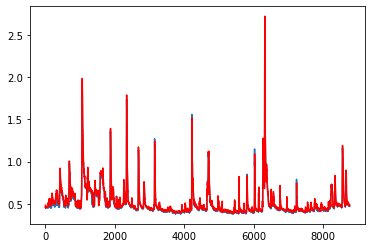

In [49]:
testPredict = model01.predict(testX01)
testAnswer = testY01.copy()

print(testPredict.shape, testAnswer.shape)

pad_col = np.zeros(dataset.shape[1]-1)
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

testPredict = scaler.inverse_transform(pad_array(testPredict))
testAnswer = scaler.inverse_transform(pad_array(testAnswer))
print(testPredict.shape, testAnswer.shape)

plt.plot(testAnswer[:, 0])
plt.plot(testPredict[:, 0], color='red')

In [0]:
viewRange2016()

## a

In [0]:
def create_dataset02(dataset, look_back=1, look_after=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_after):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        
        yset = dataset[i + look_back: i+look_back + look_after, 0].T
        dataY.append(yset)      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [26]:
look_back = 6
look_after=6
trainX02, trainY2 = create_dataset02(train, look_back, look_after)
testX02, testY02 = create_dataset02(test, look_back, look_after)
print(trainX02.shape, trainY2.shape)
print(testX02.shape, testY02.shape)

(26292, 14, 6) (26292, 6)
(8772, 14, 6) (8772, 6)


In [27]:
# create and fit the LSTM network
model02 = tf.keras.Sequential()
model02.add(tf.keras.layers.LSTM(20, input_shape=(trainX02.shape[1], trainX02.shape[2])))	#shape：変数数、遡る時間数
model02.add(tf.keras.layers.Dense(look_after))
model02.compile(loss='mean_squared_error', optimizer='adam')
model02.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2160      
_________________________________________________________________
dense (Dense)                (None, 6)                 126       
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [28]:
early_sropping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history = model02.fit(trainX02, trainY2, 
                    epochs=1000, 
                    batch_size=128, 
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[early_sropping])

Train on 23662 samples, validate on 2630 samples
Epoch 1/1000
23662/23662 - 9s - loss: 0.0058 - val_loss: 0.0020
Epoch 2/1000
23662/23662 - 1s - loss: 0.0018 - val_loss: 0.0015
Epoch 3/1000
23662/23662 - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 4/1000
23662/23662 - 1s - loss: 9.3698e-04 - val_loss: 0.0011
Epoch 5/1000
23662/23662 - 1s - loss: 7.5279e-04 - val_loss: 8.3889e-04
Epoch 6/1000
23662/23662 - 1s - loss: 6.7097e-04 - val_loss: 0.0012
Epoch 7/1000
23662/23662 - 1s - loss: 6.4649e-04 - val_loss: 0.0016
Epoch 8/1000
23662/23662 - 1s - loss: 6.0596e-04 - val_loss: 9.8217e-04
Epoch 9/1000
23662/23662 - 1s - loss: 5.8052e-04 - val_loss: 0.0012
Epoch 10/1000
23662/23662 - 1s - loss: 5.4963e-04 - val_loss: 7.1151e-04
Epoch 11/1000
23662/23662 - 1s - loss: 5.5285e-04 - val_loss: 9.7508e-04
Epoch 12/1000
23662/23662 - 1s - loss: 5.1996e-04 - val_loss: 0.0012
Epoch 13/1000
23662/23662 - 1s - loss: 4.8724e-04 - val_loss: 6.8832e-04
Epoch 14/1000
23662/23662 - 1s - loss: 5.0042e-04 - val

In [0]:
model02.save("/content/drive/My Drive/Google Colab/model02.h5")

(8772, 6) (8772, 6)
(35088, 14)
(8772, 6) (8772, 6)


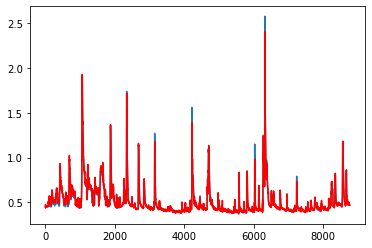

In [40]:
testPredict = model02.predict(testX02)
testAnswer = testY02.copy()
print(testPredict.shape, testAnswer.shape)

print(dataset.shape)
pad_col = np.zeros(dataset.shape[1]-1)
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

testPredict02 = np.zeros_like(testPredict)
for i in range(testPredict.shape[1]):
  tmp = scaler.inverse_transform(pad_array(testPredict[:, i]))
  testPredict02[:, i] = tmp[:, 0].copy()

testAnswer02 = np.zeros_like(testAnswer)
for i in range(testPredict.shape[1]):
  tmp = scaler.inverse_transform(pad_array(testAnswer[:, i]))
  testAnswer02[:, i] = tmp[:, 0].copy()

print(testPredict02.shape, testAnswer02.shape)

plt.plot(testAnswer02[:, 0])
plt.plot(testPredict02[:, 0], color='red')

In [0]:
def viewRange2016(_predict, _answer, _target, _tap):
  
  dst_x = np.arange(_target-_tap, _target+_tap)
  plt.plot(dst_x, _answer[dst_x, 0])
  plt.plot(dst_x, _predict[dst_x, 0], 'red')
  return

In [0]:
def viewRange2016future(_predict, _answer, _target, _tap, _ppp):

  dst_x = np.arange(_target-_tap, _target+_tap)
  plt.plot(dst_x, _answer[dst_x, 0])
  plt.plot(dst_x, _predict[dst_x, 0], 'red')

  plt.plot(np.arange(dst_x[_ppp[0]], dst_x[_ppp[0]] + 6), _predict[dst_x[_ppp[0]], :], 'mo')
  plt.plot(np.arange(dst_x[_ppp[1]], dst_x[_ppp[1]] + 6), _predict[dst_x[_ppp[1]], :], 'go')
  plt.plot(np.arange(dst_x[_ppp[2]], dst_x[_ppp[2]] + 6), _predict[dst_x[_ppp[2]], :], 'ko')
  plt.plot(np.arange(dst_x[_ppp[3]], dst_x[_ppp[3]] + 6), _predict[dst_x[_ppp[3]], :], 'mo')
  plt.plot(np.arange(dst_x[_ppp[4]], dst_x[_ppp[4]] + 6), _predict[dst_x[_ppp[4]], :], 'go')
  plt.plot(np.arange(dst_x[_ppp[5]], dst_x[_ppp[5]] + 6), _predict[dst_x[_ppp[5]], :], 'ko')
  plt.plot(np.arange(dst_x[_ppp[6]], dst_x[_ppp[6]] + 6), _predict[dst_x[_ppp[6]], :], 'mo')
  plt.plot(np.arange(dst_x[_ppp[7]], dst_x[_ppp[7]] + 6), _predict[dst_x[_ppp[7]], :], 'go')
  
  return

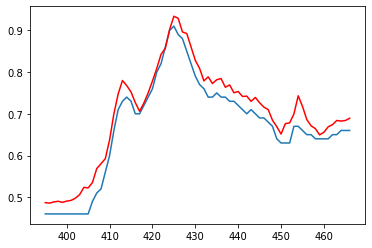

In [78]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[0], 36)

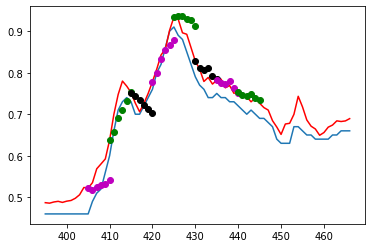

In [87]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[0], 36, [10, 15, 20, 25, 30, 35, 40, 45])

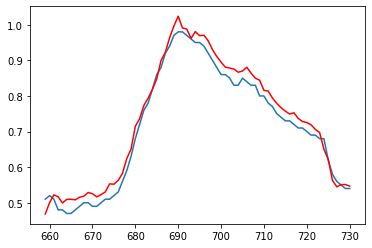

In [89]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[1], 36)

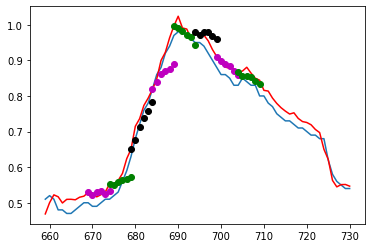

In [105]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[1], 36, [10, 15, 20, 25, 30, 35, 40, 45])

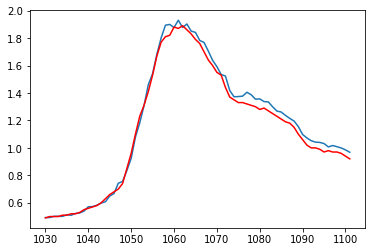

In [46]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[2], 36)

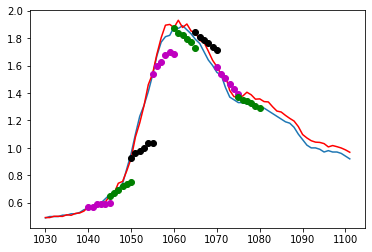

In [106]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[2], 36, [10, 15, 20, 25, 30, 35, 40, 45])

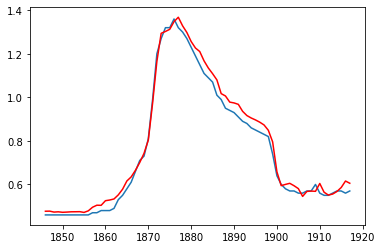

In [91]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[3], 36)

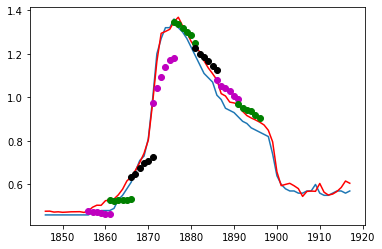

In [95]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[3], 36, [10, 15, 20, 25, 30, 35, 40, 45])

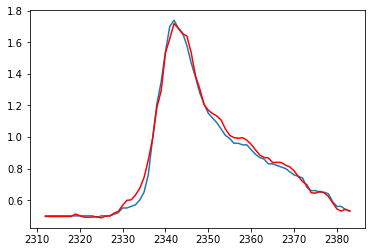

In [96]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[4], 36)

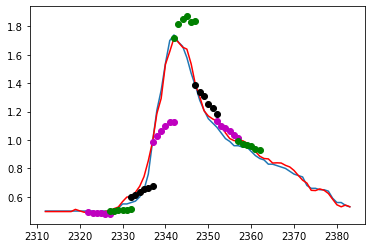

In [107]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[4], 36, [10, 15, 20, 25, 30, 35, 40, 45])

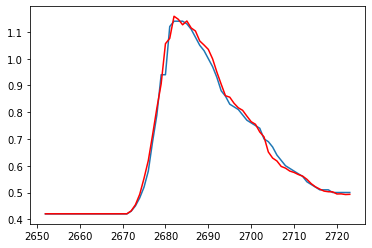

In [97]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[5], 36)

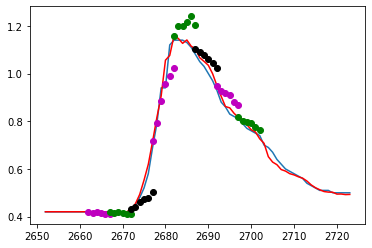

In [108]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[5], 36, [10, 15, 20, 25, 30, 35, 40, 45])

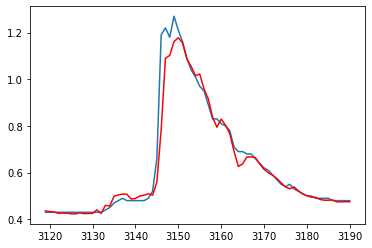

In [98]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[6], 36)

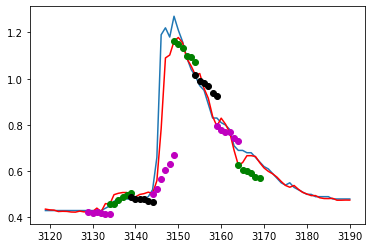

In [109]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[6], 36, [10, 15, 20, 25, 30, 35, 40, 45])

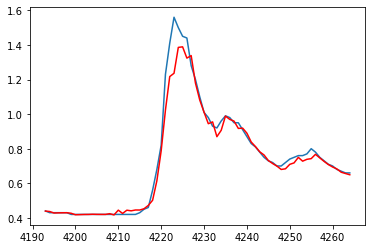

In [99]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[7], 36)

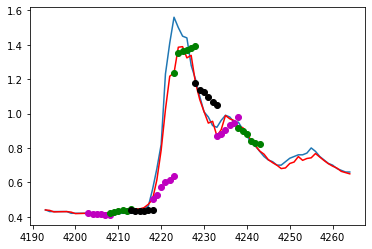

In [110]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[7], 36, [10, 15, 20, 25, 30, 35, 40, 45])

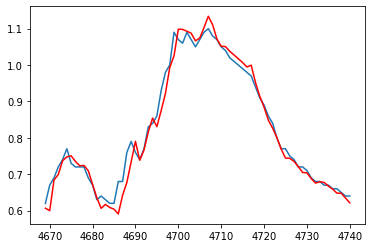

In [100]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[8], 36)

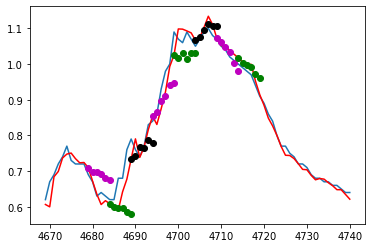

In [111]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[8], 36, [10, 15, 20, 25, 30, 35, 40, 45])

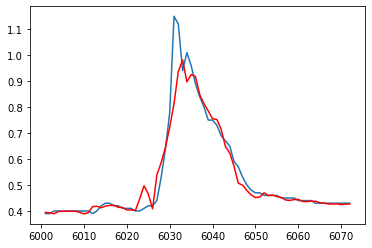

In [101]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[9], 36)

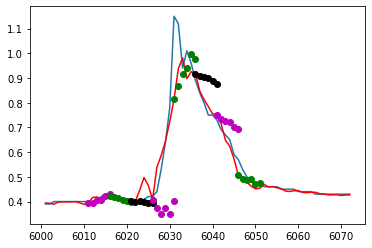

In [112]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[9], 36, [10, 15, 20, 25, 30, 35, 40, 45])

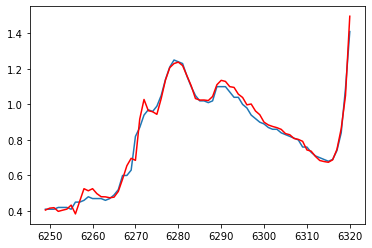

In [102]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[10], 36)

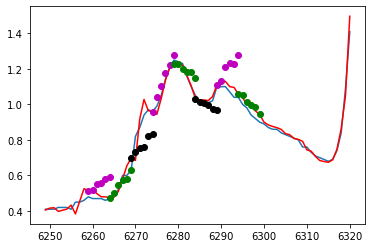

In [113]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[10], 36, [10, 15, 20, 25, 30, 35, 40, 45])

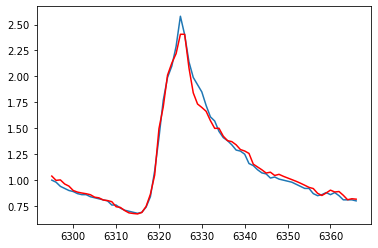

In [103]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[11], 36)

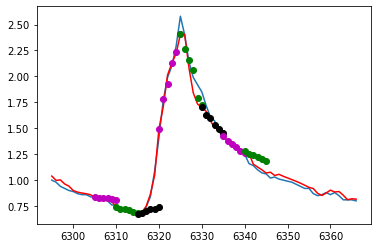

In [114]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[11], 36, [10, 15, 20, 25, 30, 35, 40, 45])

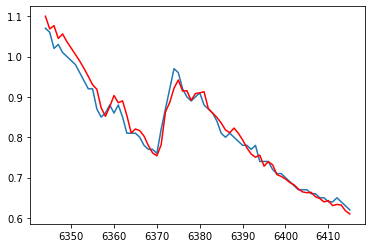

In [104]:
viewRange2016(testPredict02, testAnswer02, target_dt2016[12], 36)

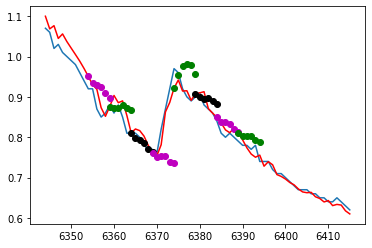

In [115]:
viewRange2016future(testPredict02, testAnswer02, target_dt2016[12], 36, [10, 15, 20, 25, 30, 35, 40, 45])

## 予測

In [0]:
def create_dataset03(dataset, look_back=1, look_after=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_after):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        for k in range(3, dataset.shape[1]):
          a = dataset[(i+look_back):(i+look_back+look_after), k]
          xset.append(a)
          
        yset = dataset[i + look_back: i+look_back + look_after, 0].T
        dataY.append(yset)      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [118]:
look_back = 6
look_after=6
trainX03, trainY03 = create_dataset03(train, look_back, look_after)
testX03, testY03 = create_dataset03(test, look_back, look_after)
print(trainX03.shape, trainY03.shape)
print(testX03.shape, testY03.shape)

(26292, 25, 6) (26292, 6)
(8772, 25, 6) (8772, 6)


In [125]:
# create and fit the LSTM network
model03 = tf.keras.Sequential()
model03.add(tf.keras.layers.LSTM(20, input_shape=(trainX03.shape[1], trainX03.shape[2])))	#shape：変数数、遡る時間数
model03.add(tf.keras.layers.Dense(look_after))
model03.compile(loss='mean_squared_error', optimizer='adam')
model03.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [126]:
early_sropping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history = model03.fit(trainX03, trainY03, 
                    epochs=1000, 
                    batch_size=128, 
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[early_sropping])

Train on 23662 samples, validate on 2630 samples
Epoch 1/1000
23662/23662 - 2s - loss: 0.0061 - val_loss: 0.0025
Epoch 2/1000
23662/23662 - 1s - loss: 0.0018 - val_loss: 0.0014
Epoch 3/1000
23662/23662 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 4/1000
23662/23662 - 1s - loss: 0.0010 - val_loss: 0.0011
Epoch 5/1000
23662/23662 - 1s - loss: 8.9463e-04 - val_loss: 0.0012
Epoch 6/1000
23662/23662 - 1s - loss: 8.1506e-04 - val_loss: 9.2870e-04
Epoch 7/1000
23662/23662 - 1s - loss: 8.0346e-04 - val_loss: 7.4549e-04
Epoch 8/1000
23662/23662 - 1s - loss: 7.9004e-04 - val_loss: 7.3537e-04
Epoch 9/1000
23662/23662 - 1s - loss: 7.4941e-04 - val_loss: 7.1707e-04
Epoch 10/1000
23662/23662 - 1s - loss: 7.6231e-04 - val_loss: 8.2996e-04
Epoch 11/1000
23662/23662 - 1s - loss: 7.0272e-04 - val_loss: 0.0011
Epoch 12/1000
23662/23662 - 1s - loss: 6.9263e-04 - val_loss: 9.7080e-04
Epoch 13/1000
23662/23662 - 1s - loss: 6.7793e-04 - val_loss: 9.1349e-04
Epoch 14/1000
23662/23662 - 1s - loss: 6.6478e-04 -

In [0]:
model03.save("/content/drive/My Drive/Google Colab/model03.h5")

(8772, 6) (8772, 6)
(35088, 14)
(8772, 6) (8772, 6)


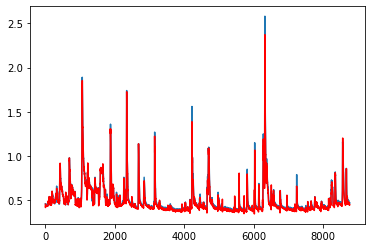

In [128]:
testPredict = model03.predict(testX03)
testAnswer = testY03.copy()
print(testPredict.shape, testAnswer.shape)

print(dataset.shape)
pad_col = np.zeros(dataset.shape[1]-1)
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

testPredict03 = np.zeros_like(testPredict)
for i in range(testPredict.shape[1]):
  tmp = scaler.inverse_transform(pad_array(testPredict[:, i]))
  testPredict03[:, i] = tmp[:, 0].copy()

testAnswer03 = np.zeros_like(testAnswer)
for i in range(testPredict.shape[1]):
  tmp = scaler.inverse_transform(pad_array(testAnswer[:, i]))
  testAnswer03[:, i] = tmp[:, 0].copy()

print(testPredict03.shape, testAnswer03.shape)

plt.plot(testAnswer03[:, 0])
plt.plot(testPredict03[:, 0], color='red')

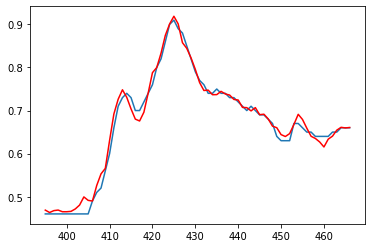

In [129]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[0], 36)

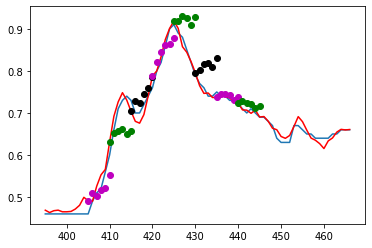

In [131]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[0], 36, [10, 15, 20, 25, 30, 35, 40, 45])

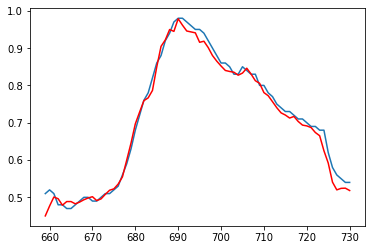

In [132]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[1], 36)

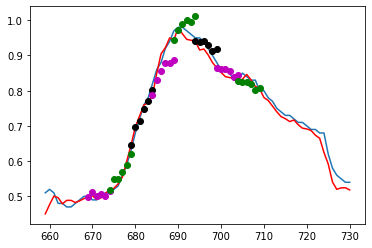

In [133]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[1], 36, [10, 15, 20, 25, 30, 35, 40, 45])

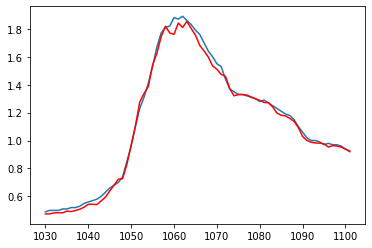

In [134]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[2], 36)

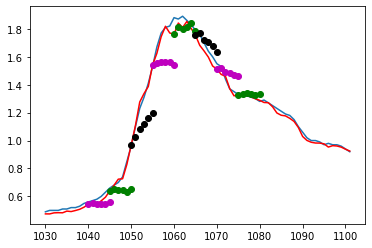

In [145]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[2], 36, [10, 15, 20, 25, 30, 35, 40, 45])

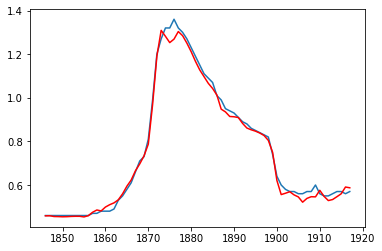

In [135]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[3], 36)

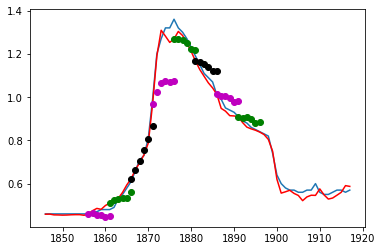

In [146]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[3], 36, [10, 15, 20, 25, 30, 35, 40, 45])

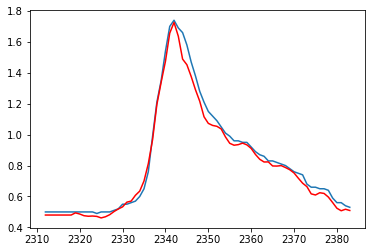

In [136]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[4], 36)

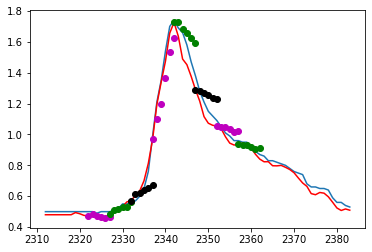

In [147]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[4], 36, [10, 15, 20, 25, 30, 35, 40, 45])

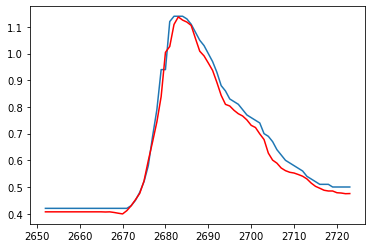

In [137]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[5], 36)

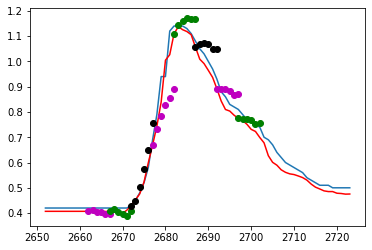

In [148]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[5], 36, [10, 15, 20, 25, 30, 35, 40, 45])

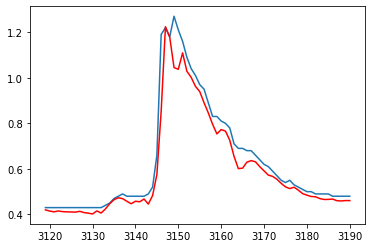

In [138]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[6], 36)

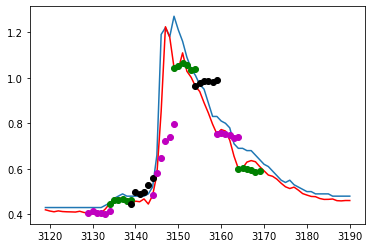

In [149]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[6], 36, [10, 15, 20, 25, 30, 35, 40, 45])

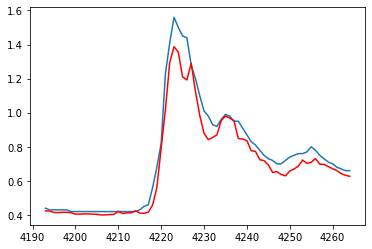

In [139]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[7], 36)

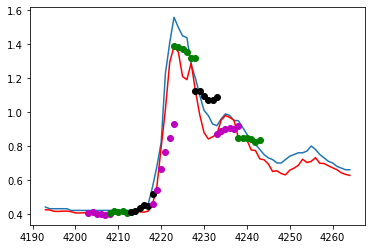

In [150]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[7], 36, [10, 15, 20, 25, 30, 35, 40, 45])

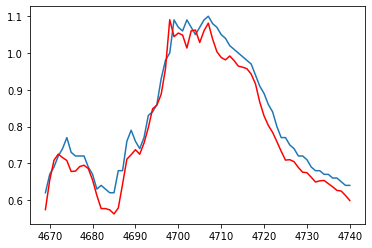

In [140]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[8], 36)

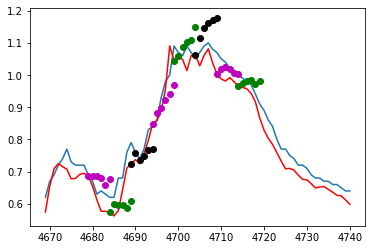

In [151]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[8], 36, [10, 15, 20, 25, 30, 35, 40, 45])

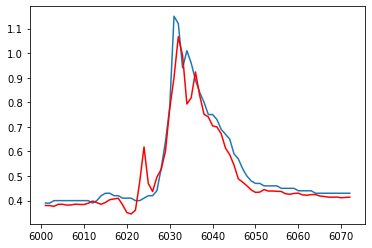

In [141]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[9], 36)

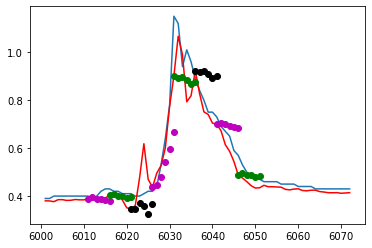

In [152]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[9], 36, [10, 15, 20, 25, 30, 35, 40, 45])

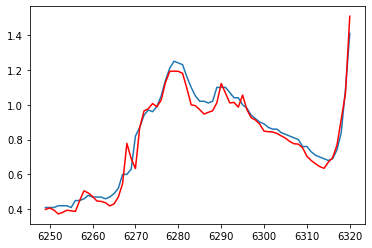

In [142]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[10], 36)

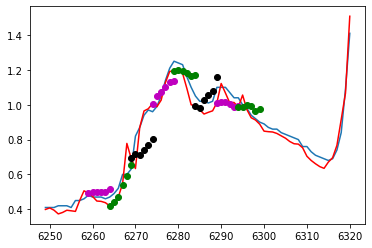

In [153]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[10], 36, [10, 15, 20, 25, 30, 35, 40, 45])

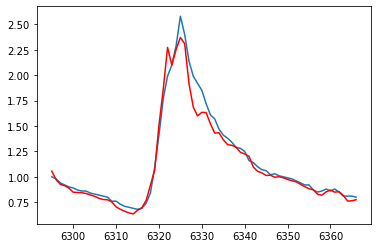

In [143]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[11], 36)

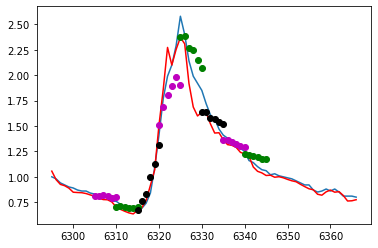

In [154]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[11], 36, [10, 15, 20, 25, 30, 35, 40, 45])

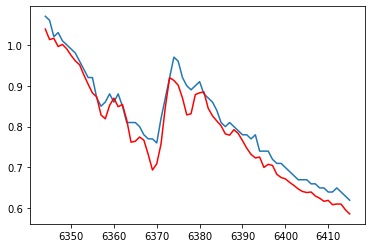

In [144]:
viewRange2016(testPredict03, testAnswer03, target_dt2016[12], 36)

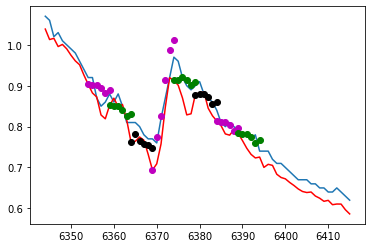

In [155]:
viewRange2016future(testPredict03, testAnswer03, target_dt2016[12], 36, [10, 15, 20, 25, 30, 35, 40, 45])

In [86]:
testPredict2 = model2.predict(testX2)
print(testX2.shape, testX2.dtype)
print(testPredict2.shape, testPredict2.dtype)

(8772, 14, 6) float32
(8772, 6) float32


In [82]:
testPredict2 = model2.predict(testX2)
testAnswer2 = testY2.copy()
print(dataset.shape[1], testAnswer2.shape)
targetDT = [1064, 1066, 1880, 1882, 2348, 2688, 3153, 3155, 4229, 5590, 6037, 6040, 6285, 6331, 7247, 8572]

pad_col = np.zeros(dataset.shape[1]-1)
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

for i in range(testX2.shape[1]):
  testPredict2[:, i] = scaler.inverse_transform(pad_array(testPredict2[:, i]))

testAnswer2 = scaler.inverse_transform(pad_array(testAnswer2))

tap=36


plt.plot(testAnswer[targetDT[8]-tap:targetDT[8]+tap, 0])
plt.plot(testPredict[targetDT[8]-tap:targetDT[8]+tap, 0], color='red')

plt.show()

14 (8772, 6)


ValueError: ignored

/tensorflow-2.1.0/python3.6/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/tensorflow-2.1.0/python3.6/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


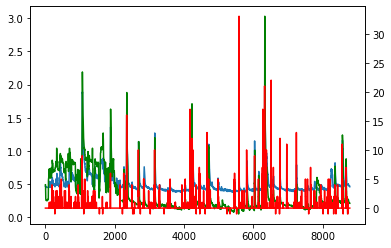

target     184
diff       280
river_0     40
rain_0       0
dtype: int64
target     0
diff       0
river_0    0
rain_0     0
dtype: int64


In [8]:
src_data = getYearData(2016)
target_data = pd.DataFrame(src_data['水位:小舟渡'].values.astype(np.float32), index=src_data.index, columns=['target'])
target_data['diff'] = target_data.diff()
target_data['river_0'] = src_data['水位:松丸'].values.astype(np.float32)
target_data['rain_0'] = src_data['勝山分庁舎'].values.astype(np.float32)

fig, ax1=plt.subplots()
ax1.plot(target_data['target'].values.astype(np.float32))
ax1.plot(target_data['river_0'].values.astype(np.float32), color='green')
ax2 = ax1.twinx()
ax2.plot(target_data['rain_0'].values.astype(np.float32),color='red')
plt.show()

print(target_data.isnull().sum())
target_data = target_data.fillna(target_data.mean())
print(target_data.isnull().sum())

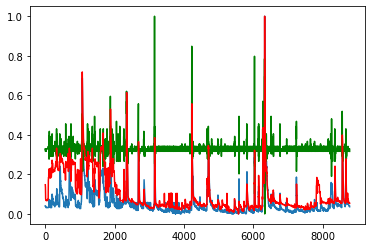

In [9]:
dataset = target_data.values.astype(np.float32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

plt.plot(dataset[:, 0])
plt.plot(dataset[:, 1], color='green')
plt.plot(dataset[:, 2], color='red')


In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5885 2899


In [0]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)

        dataY.append(dataset[i + look_back, 0])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 9
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainX[0])
print(trainY)


(5859, 4, 9)
[[0.270115   0.270115   0.270115   0.270115   0.270115   0.270115
  0.270115   0.2758621  0.28160924]
 [0.27115592 0.27118653 0.27118653 0.27118653 0.27118653 0.27118653
  0.27118653 0.28813565 0.28813565]
 [0.21962616 0.21962616 0.21962616 0.21962616 0.21495326 0.21028036
  0.21495326 0.21495326 0.21495326]
 [0.06666667 0.04444445 0.04444445 0.06666667 0.02222222 0.04444445
  0.02222222 0.04444445 0.06666667]]
[0.2758621  0.2758621  0.2758621  ... 0.24712646 0.24712646 0.24137935]


In [0]:
print(trainX.shape, trainY.shape)

(5859, 1, 9) (5859,)


In [0]:
print(np.isnan(sTrainX).sum())

0


In [0]:

# create and fit the LSTM network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(4, input_shape=(trainX.shape[1], look_back)))	#shape：変数数、遡る時間数
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
early_sropping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=20)

history = model.fit(trainX, trainY, 
                    epochs=1000, 
                    batch_size=128, 
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[early_sropping])

Train on 5273 samples, validate on 586 samples
Epoch 1/1000
5273/5273 - 1s - loss: 0.0289 - val_loss: 0.0160
Epoch 2/1000
5273/5273 - 0s - loss: 0.0143 - val_loss: 0.0165
Epoch 3/1000
5273/5273 - 0s - loss: 0.0111 - val_loss: 0.0114
Epoch 4/1000
5273/5273 - 0s - loss: 0.0080 - val_loss: 0.0058
Epoch 5/1000
5273/5273 - 0s - loss: 0.0060 - val_loss: 0.0027
Epoch 6/1000
5273/5273 - 0s - loss: 0.0050 - val_loss: 0.0011
Epoch 7/1000
5273/5273 - 0s - loss: 0.0047 - val_loss: 0.0011
Epoch 8/1000
5273/5273 - 0s - loss: 0.0045 - val_loss: 7.8361e-04
Epoch 9/1000
5273/5273 - 0s - loss: 0.0044 - val_loss: 6.5175e-04
Epoch 10/1000
5273/5273 - 0s - loss: 0.0043 - val_loss: 9.7184e-04
Epoch 11/1000
5273/5273 - 0s - loss: 0.0042 - val_loss: 8.2514e-04
Epoch 12/1000
5273/5273 - 0s - loss: 0.0041 - val_loss: 5.5450e-04
Epoch 13/1000
5273/5273 - 0s - loss: 0.0040 - val_loss: 5.7850e-04
Epoch 14/1000
5273/5273 - 0s - loss: 0.0038 - val_loss: 8.5279e-04
Epoch 15/1000
5273/5273 - 0s - loss: 0.0038 - val_lo

In [0]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
testPredict.shape

(2881, 1)

In [0]:
pad_col = np.zeros(dataset.shape[1]-1)
def pad_array(val):
    return np.array([np.insert(pad_col, 0, x) for x in val])

trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))

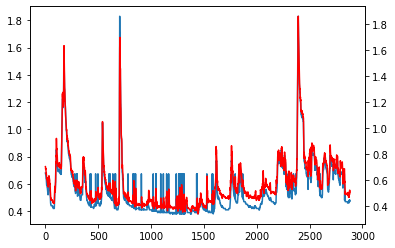

In [0]:
fig, ax1=plt.subplots()
ax1.plot(testY[:, 0])
ax2 = ax1.twinx()
ax2.plot(testPredict[:, 0], color='red')
plt.show()

['日時' '水位:松丸' '水位:比島' '水位:小舟渡' '朝日前坂' '下山' '上大納' '小黒見' '浄土寺川ダム' '下黒谷'
 '奥越土木' '勝山分庁舎' '牧福島' '永平寺ダム' '東古市' 'mean' 'diff' 'argrelmax']


/tensorflow-2.1.0/python3.6/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/tensorflow-2.1.0/python3.6/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater


array([ 431,  695, 1064, 1066, 1880, 1882, 2348, 2685, 2688, 3153, 3155,
       4229, 4705, 4708, 6037, 6040, 6279, 6285, 6331, 6380, 8572])

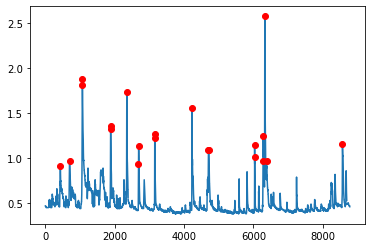

In [47]:
data2016 = getYearData(2016)
peak2016 = getYearPeak(data2016)
peak2016.index.values

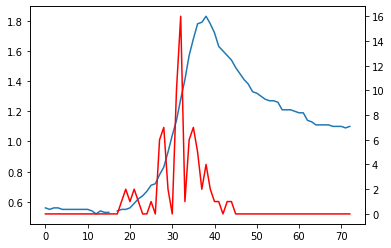

In [0]:
a = getRangeData(data2015, 8268, 36, 36)
fig, ax1=plt.subplots()
ax1.plot(a['水位:小舟渡'].values.astype(np.float32))
ax2 = ax1.twinx()
ax2.plot(a['勝山分庁舎'].values.astype(np.float32),color='red')
plt.show()

In [0]:
sTrainX = trainX.reshape([trainX.shape[0], -1]).copy()
sTrainY = trainY.reshape([trainY.shape[0], 1]).copy()
sTrainY=sTrainY[~np.isnan(sTrainX).any(axis=1), :].reshape([-1])
sTrainX=sTrainX[~np.isnan(sTrainX).any(axis=1), :].reshape([-1, trainX.shape[1], trainX.shape[2]])
print(sTrainX.shape, sTrainY.shape)

(5859, 4, 9) (5859,)
